In [1]:
# Instalasi pustaka yang diperlukan
!pip install -q sastrawi faiss-cpu sentence-transformers transformers accelerate networkx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.0 MB/s eta 0:00:00


In [2]:
# Impor pustaka
import requests
import json
import networkx as nx
import numpy as np
import faiss
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import matplotlib.pyplot as plt

In [5]:
# Unduh dataset
url = "https://raw.githubusercontent.com/Nocturnailed-Community/Pamolah-Intelegent/refs/heads/main/Datasets/NLP/enriched_teeth_dataset.json"
response = requests.get(url)
dataset = response.json() if response.status_code == 200 else []

# Ekstrak teks dan label
texts = [f"{entry['keluhan_umum']} {entry['lokasi_nyeri']} {entry['durasi_masalah']} {entry['gejala_tambahan']} {entry['analisis']} {entry['rekomendasi']}" for entry in dataset]
labels = [entry['kelas'] for entry in dataset]

# Encoding label
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [6]:
# Bangun graph dari dataset
graph = nx.Graph()
for entry in dataset:
    nodes = [entry['keluhan_umum'], entry['lokasi_nyeri'], entry['durasi_masalah'], entry['gejala_tambahan'], entry['analisis'], entry['rekomendasi'], entry['kelas']]
    for node in nodes:
        graph.add_node(node)
    edges = [(entry['keluhan_umum'], entry['lokasi_nyeri']),
             (entry['lokasi_nyeri'], entry['durasi_masalah']),
             (entry['durasi_masalah'], entry['gejala_tambahan']),
             (entry['gejala_tambahan'], entry['analisis']),
             (entry['rekomendasi'], entry['kelas'])]
    graph.add_edges_from(edges)

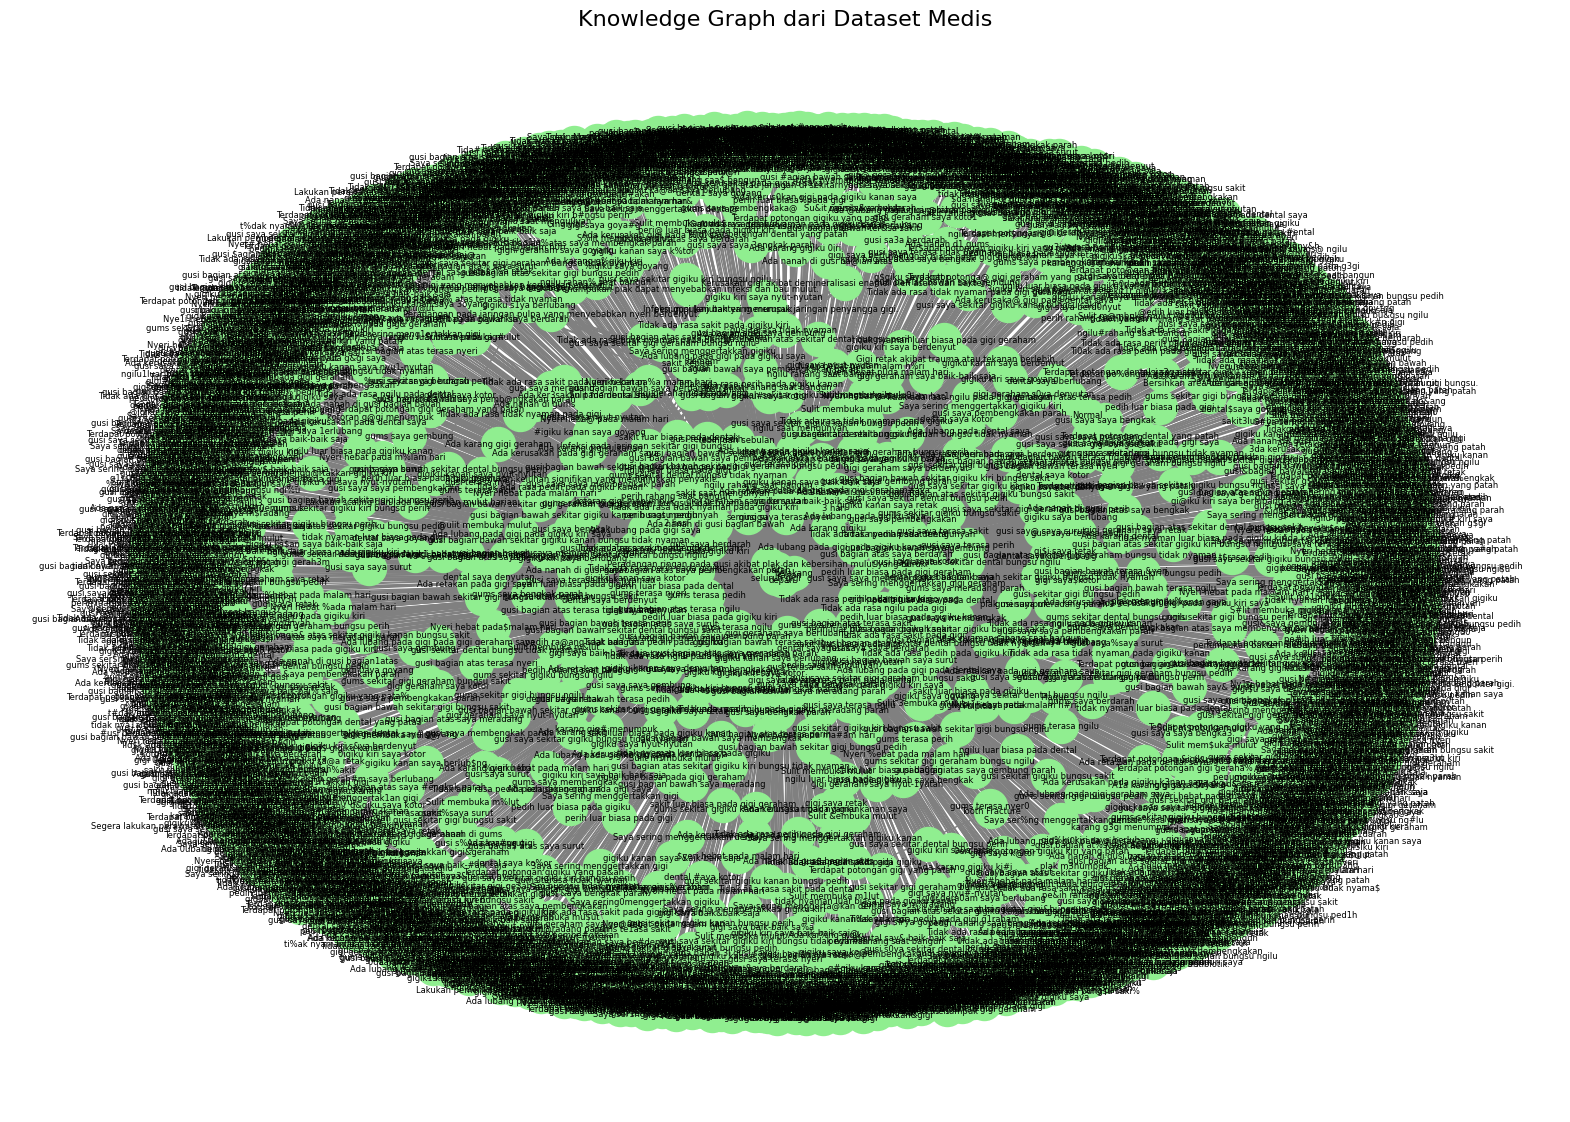

In [7]:
plt.figure(figsize=(20, 14))
pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=42)
nx.draw_networkx(graph, pos,
                 with_labels=True,
                 node_size=600,
                 font_size=6,
                 node_color="lightgreen",
                 edge_color="gray")
plt.title("Knowledge Graph dari Dataset Medis", fontsize=16)
plt.axis("off")
plt.show()

In [8]:
# Gunakan SentenceTransformer untuk embedding
embedding_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
embeddings = embedding_model.encode(texts, convert_to_numpy=True)

# Bangun indeks FAISS
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
# Muat tokenizer dan model
model_name = "GoToCompany/llama3-8b-cpt-sahabatai-v1-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/143 [00:00<?, ?B/s]

In [10]:
def classify_medical_text(user_input, top_k=3):
    # Step 1: Buat embedding dari input pengguna
    input_embedding = embedding_model.encode([user_input], convert_to_numpy=True)

    # Step 2: Temukan top_k teks yang paling mirip
    distances, indices = index.search(input_embedding, top_k)
    retrieved_entries = [dataset[i] for i in indices[0]]
    retrieved_texts = [texts[i] for i in indices[0]]
    retrieved_labels = [labels[i] for i in indices[0]]

    # Step 3: Siapkan prompt awal
    prompt = "Anda adalah asisten medis pintar. Berdasarkan beberapa catatan medis berikut:\n"

    for i, entry in enumerate(retrieved_entries):
        label = entry['kelas']
        text = f"{entry['keluhan_umum']} {entry['lokasi_nyeri']} {entry['durasi_masalah']} {entry['gejala_tambahan']}  {entry['analisis']}  {entry['rekomendasi']}"
        prompt += f"- {text} (Label: {label})\n"

        # Relasi dari graph
        components = [entry['keluhan_umum'], entry['lokasi_nyeri'], entry['durasi_masalah'],
                      entry['gejala_tambahan'], entry['analisis'], entry['rekomendasi']]
        for node in components:
            if node in graph:
                neighbors = list(graph.neighbors(node))
                if neighbors:
                    prompt += f"  ↳ Relasi graf dari '{node}': {', '.join(neighbors)}\n"

    # Step 4: Tambahkan input pengguna dan instruksi klasifikasi, analisis, dan rekomendasi
    prompt += (
        f"\nTentukan kelas keluhan medis, analisis, dan rekomendasi paling sesuai untuk input pasien berikut:\n"
        f"\"{user_input}\"\n"
        f"Jawab dalam format:\n"
        f"Label: <nama_kelas>\n"
        f"Analisis: <analisis>\n"
        f"Rekomendasi: <rekomendasi>\n"
    )

    # Step 5: Tokenisasi dan inferensi LLM
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)
    output = model.generate(**inputs, max_new_tokens=200)
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

    # Step 6: Ekstrak Label, Analisis, dan Rekomendasi dari Output
    import re

    label_match = re.search(r'Label:\s*(.*)', decoded_output)
    analysis_match = re.search(r'Analisis:\s*(.*)', decoded_output)
    recommendation_match = re.search(r'Rekomendasi:\s*(.*)', decoded_output)

    matched_class = label_match.group(1).strip() if label_match else None
    analysis = analysis_match.group(1).strip() if analysis_match else None
    recommendation = recommendation_match.group(1).strip() if recommendation_match else None

    # Fallback jika tidak dikenali
    if not matched_class:
        matched_class = max(set(retrieved_labels), key=retrieved_labels.count)
    if not analysis:
        analysis = max([entry['analisis'] for entry in retrieved_entries], key=len)
    if not recommendation:
        recommendation = max([entry['rekomendasi'] for entry in retrieved_entries], key=len)

    return {
        "kelas": matched_class,
        "analisis": analysis,
        "rekomendasi": recommendation,
        "raw_output": decoded_output  # opsional: untuk debugging
    }

In [11]:
# Contoh input
user_input = "saya merasa nyeri di bagian belakang gigi"

# Klasifikasi
prediction = classify_medical_text(user_input)
print("Hasil Prediksi:\n", prediction)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Hasil Prediksi:
 {'kelas': 'Pulpitis)', 'analisis': 'Peradangan pada jaringan pulpa yang menyebabkan nyeri berdenyut.', 'rekomendasi': 'Lakukan perawatan saluran akar oleh dokter gigi.', 'raw_output': "Anda adalah asisten medis pintar. Berdasarkan beberapa catatan medis berikut:\n- gigiku kanan saya berdenyut belakang 1 hari bau mulut  Peradangan pada jaringan pulpa yang menyebabkan nyeri berdenyut.  Lakukan perawatan saluran akar oleh dokter gigi. (Label: Pulpitis)\n  ↳ Relasi graf dari 'gigiku kanan saya berdenyut': kanan, depan, seluruh gigi, belakang, kiri\n  ↳ Relasi graf dari 'belakang': Sulit membuka mul3t, seminggu, Nyeri hebat pada malam hari, 2 hari, Saya sering menggertakkan gigi geraham, Sulit membuka mulut, Saya sering menggertakkan gigiku kiri, @ums terasa nyeri, lebih dari sebulan, sakit luar biasa pada gigi, gusi bagian atas terasa nyeri, 1 hari, perih luar biasa pada gigiku, 3 hari, Terdapat potongan gigiku kanan yang patah, Ada karang gigi geraham, Tidak ada rasa tida

In [12]:
test_inputs = [
    "saya merasa nyeri di bagian belakang gigi",
    "gigi saya sakit dan ngilu sampai ke kepala",
    "nyeri tajam di rahang kiri sudah seminggu",
    "sakit di bagian gusi, terasa bengkak",
    "ngilu tiap minum dingin dan makan manis",
    "rasa sakit konstan di pipi bagian dalam",
    "gusi berdarah dan bengkak saat menyikat gigi",
    "nyeri berdenyut pada malam hari di gigi kanan bawah",
    "sakit saat menggigit makanan keras",
    "rasa nyut-nyutan di sekitar gigi geraham belakang"
]

# Uji semua input
for i, input_text in enumerate(test_inputs, 1):
    prediction = classify_medical_text(input_text)
    print(f"Input {i}: {input_text}")
    print(f"→ Prediksi: {prediction}\n")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Input 1: saya merasa nyeri di bagian belakang gigi
→ Prediksi: {'kelas': 'Pulpitis)', 'analisis': 'Peradangan pada jaringan pulpa yang menyebabkan nyeri berdenyut.', 'rekomendasi': 'Lakukan perawatan saluran akar oleh dokter gigi.', 'raw_output': "Anda adalah asisten medis pintar. Berdasarkan beberapa catatan medis berikut:\n- gigiku kanan saya berdenyut belakang 1 hari bau mulut  Peradangan pada jaringan pulpa yang menyebabkan nyeri berdenyut.  Lakukan perawatan saluran akar oleh dokter gigi. (Label: Pulpitis)\n  ↳ Relasi graf dari 'gigiku kanan saya berdenyut': kanan, depan, seluruh gigi, belakang, kiri\n  ↳ Relasi graf dari 'belakang': Sulit membuka mul3t, seminggu, Nyeri hebat pada malam hari, 2 hari, Saya sering menggertakkan gigi geraham, Sulit membuka mulut, Saya sering menggertakkan gigiku kiri, @ums terasa nyeri, lebih dari sebulan, sakit luar biasa pada gigi, gusi bagian atas terasa nyeri, 1 hari, perih luar biasa pada gigiku, 3 hari, Terdapat potongan gigiku kanan yang patah

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Input 2: gigi saya sakit dan ngilu sampai ke kepala
→ Prediksi: {'kelas': 'Gingivitis)', 'analisis': 'Peradangan ringan pada gusi akibat plak dan kebersihan mulut yang buruk.', 'rekomendasi': 'Lakukan pemeriksaan rontgen dan tindakan konservatif atau pencabutan jika parah.', 'raw_output': "Anda adalah asisten medis pintar. Berdasarkan beberapa catatan medis berikut:\n- gusi bagian bawah saya berdarah kanan 1 hari sakit kepala  Peradangan ringan pada gusi akibat plak dan kebersihan mulut yang buruk.  Lakukan scaling dan jaga kebersihan mulut harian. (Label: Gingivitis)\n  ↳ Relasi graf dari 'gusi bagian bawah saya berdarah': depan, belakang, kiri, seluruh gigi, kanan\n  ↳ Relasi graf dari 'kanan': Ada karang gigi, 2 hari, Ada&nanah di gusi saya, 1 hari, gigiku ka$an saya berlubang, lebih dari sebulan, Tidak ada rasa p1rih pada dental, perih rahang saat bangun, Ada nanah di gusi bagian bawah, dental saya goyang, gigi saya goyang, gusi bagian bawah saya meradang, Tidak ada rasa sakit pada

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Input 3: nyeri tajam di rahang kiri sudah seminggu
→ Prediksi: {'kelas': 'Pulpitis)', 'analisis': 'Peradangan pada jaringan pulpa yang menyebabkan nyeri berdenyut.', 'rekomendasi': 'Lakukan perawatan saluran akar oleh dokter gigi.', 'raw_output': "Anda adalah asisten medis pintar. Berdasarkan beberapa catatan medis berikut:\n- %igiku kiri saya denyutan belakang seminggu sakit kepala  Peradangan pada jaringan pulpa yang menyebabkan nyeri berdenyut.  Lakukan perawatan saluran akar oleh dokter gigi. (Label: Pulpitis)\n  ↳ Relasi graf dari '%igiku kiri saya denyutan': belakang\n  ↳ Relasi graf dari 'belakang': Sulit membuka mul3t, seminggu, Nyeri hebat pada malam hari, 2 hari, Saya sering menggertakkan gigi geraham, Sulit membuka mulut, Saya sering menggertakkan gigiku kiri, @ums terasa nyeri, lebih dari sebulan, sakit luar biasa pada gigi, gusi bagian atas terasa nyeri, 1 hari, perih luar biasa pada gigiku, 3 hari, Terdapat potongan gigiku kanan yang patah, Ada karang gigi geraham, Tidak 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Input 4: sakit di bagian gusi, terasa bengkak
→ Prediksi: {'kelas': 'Abscess)', 'analisis': 'Infeksi pada akar gigi atau jaringan di sekitarnya menyebabkan abses.', 'rekomendasi': 'Segera lakukan perawatan saluran akar atau pengeluaran nanah oleh dokter.', 'raw_output': "Anda adalah asisten medis pintar. Berdasarkan beberapa catatan medis berikut:\n- sakit luar biasa pada gigiku kanan 1 hari bau mulut  Infeksi pada akar gigi atau jaringan di sekitarnya menyebabkan abses.  Segera lakukan perawatan saluran akar atau pengeluaran nanah oleh dokter. (Label: Abscess)\n  ↳ Relasi graf dari'sakit luar biasa pada gigiku': depan, kanan, belakang, seluruh gigi, kiri\n  ↳ Relasi graf dari 'kanan': Ada karang gigi, 2 hari, Ada&nanah di gusi saya, 1 hari, gigiku ka$an saya berlubang, lebih dari sebulan, Tidak ada rasa p1rih pada dental, perih rahang saat bangun, Ada nanah di gusi bagian bawah, dental saya goyang, gigi saya goyang, gusi bagian bawah saya meradang, Tidak ada rasa sakit pada dental, 3 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Input 5: ngilu tiap minum dingin dan makan manis
→ Prediksi: {'kelas': 'Gingivitis)', 'analisis': 'Peradangan ringan pada gusi akibat plak dan kebersihan mulut yang buruk.', 'rekomendasi': 'Lakukan scaling dan jaga kebersihan mulut harian.', 'raw_output': "Anda adalah asisten medis pintar. Berdasarkan beberapa catatan medis berikut:\n- gu@i bagian bawah saya meradang depan 2 hari bau mulut  Peradangan ringan pada gusi akibat plak dan kebersihan mulut yang buruk.  Lakukan scaling dan jaga kebersihan mulut harian. (Label: Gingivitis)\n  ↳ Relasi graf dari 'gu@i bagian bawah saya meradang': depan\n  ↳ Relasi graf dari 'depan': gigiku kiri saya denyutan, lebih dari sebulan, sakit luar biasa pada gigiku kiri, 3 hari, gigiku saya retak, penumpukan bakteri menumpuk, 2 hari, Nyeri hebat pada malam hari, 1 hari, Ada nanah di gusi bagian atas, seminggu, Terdapat potongan gigi yang patah, Nyeri he1at pada malam hari, tidak nyaman luar bi1sa pada gigi, Sulit membuka mulut, 3da kerusakan gigi pada 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Input 6: rasa sakit konstan di pipi bagian dalam
→ Prediksi: {'kelas': 'Pulpitis)', 'analisis': 'Peradangan pada jaringan pulpa yang menyebabkan nyeri berdenyut.', 'rekomendasi': 'Lakukan perawatan saluran akar oleh dokter gigi.', 'raw_output': "Anda adalah asisten medis pintar. Berdasarkan beberapa catatan medis berikut:\n- &igi geraham saya berdenyut kanan 2 hari sakit kepala  Peradangan pada jaringan pulpa yang menyebabkan nyeri berdenyut.  Lakukan perawatan saluran akar oleh dokter gigi. (Label: Pulpitis)\n  ↳ Relasi graf dari '&igi geraham saya berdenyut': seluruh gigi, kanan\n  ↳ Relasi graf dari 'kanan': Ada karang gigi, 2 hari, Ada&nanah di gusi saya, 1 hari, gigiku ka$an saya berlubang, lebih dari sebulan, Tidak ada rasa p1rih pada dental, perih rahang saat bangun, Ada nanah di gusi bagian bawah, dental saya goyang, gigi saya goyang, gusi bagian bawah saya meradang, Tidak ada rasa sakit pada dental, 3 hari, gigi geraham saya baik-baik saja, seminggu, gusi bagian bawah terasa n

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Input 7: gusi berdarah dan bengkak saat menyikat gigi
→ Prediksi: {'kelas': 'Gingivitis)', 'analisis': 'Peradangan ringan pada gusi akibat plak dan kebersihan mulut yang buruk.', 'rekomendasi': 'Lakukan scaling dan jaga kebersihan mulut harian.', 'raw_output': "Anda adalah asisten medis pintar. Berdasarkan beberapa catatan medis berikut:\n- gusi saya saya berdarah depan 1 hari pusing  Peradangan ringan pada gusi akibat plak dan kebersihan mulut yang buruk.  Lakukan scaling dan jaga kebersihan mulut harian. (Label: Gingivitis)\n  ↳ Relasi graf dari 'gusi saya saya berdarah': kanan, depan, seluruh gigi, kiri, belakang\n  ↳ Relasi graf dari 'depan': gigiku kiri saya denyutan, lebih dari sebulan, sakit luar biasa pada gigiku kiri, 3 hari, gigiku saya retak, penumpukan bakteri menumpuk, 2 hari, Nyeri hebat pada malam hari, 1 hari, Ada nanah di gusi bagian atas, seminggu, Terdapat potongan gigi yang patah, Nyeri he1at pada malam hari, tidak nyaman luar bi1sa pada gigi, Sulit membuka mulut, 3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Input 8: nyeri berdenyut pada malam hari di gigi kanan bawah
→ Prediksi: {'kelas': 'Bruxism)', 'analisis': 'Kebiasaan menggemeretakkan gigi yang menyebabkan kerusakan enamel.', 'rekomendasi': 'Gunakan night guard dan kelola stres.', 'raw_output': "Anda adalah asisten medis pintar. Berdasarkan beberapa catatan medis berikut:\n- sakit rahang saat ban#un kiri 1 hari mual  Kebiasaan menggemeretakkan gigi yang menyebabkan kerusakan enamel.  Gunakan night guard dan kelola stres. (Label: Bruxism)\n  ↳ Relasi graf dari'sakit rahang saat ban#un': kiri\n  ↳ Relasi graf dari 'kiri': gusi bagian bawah terasa pedih, 2 hari, gigiku kanan saya kotor, gigiku kanan saya reta@, seminggu, ngilu rahang&saat bangun, Ada karang dent&l, 1 hari, gusi saya saya3berdarah, lebih dari sebulan, gums saya meradang, gigiku kiri saya retak, gusi saya saya surut, g&gi saya denyutan, gums sekitar dental bungsu perih, gigiku saya retak, Tidak ada rasa sakit pada dental, Sulit membuka mulut, Ada$karang dental, 3 hari, gu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Input 9: sakit saat menggigit makanan keras
→ Prediksi: {'kelas': 'Gingivitis)', 'analisis': 'Peradangan ringan pada gusi akibat plak dan kebersihan mulut yang buruk.', 'rekomendasi': 'Lakukan scaling dan jaga kebersihan mulut harian.', 'raw_output': "Anda adalah asisten medis pintar. Berdasarkan beberapa catatan medis berikut:\n- gu$i terasa sakit kanan 1 hari demam  Peradangan ringan pada gusi akibat plak dan kebersihan mulut yang buruk.  Lakukan scaling dan jaga kebersihan mulut harian. (Label: Gingivitis)\n  ↳ Relasi graf dari 'gu$i terasa sakit': kanan\n  ↳ Relasi graf dari 'kanan': Ada karang gigi, 2 hari, Ada&nanah di gusi saya, 1 hari, gigiku ka$an saya berlubang, lebih dari sebulan, Tidak ada rasa p1rih pada dental, perih rahang saat bangun, Ada nanah di gusi bagian bawah, dental saya goyang, gigi saya goyang, gusi bagian bawah saya meradang, Tidak ada rasa sakit pada dental, 3 hari, gigi geraham saya baik-baik saja, seminggu, gusi bagian bawah terasa nyeri, Sulit membuka mulu